# Creation of Diurnal Cycle Figure

Here we will be creating the figure displaying the diurnal cycle of severe and non-severe events by UTC hour.

Plot a) will contain the labeled data (ground truth) diurnal cycle and plots b-f) will contain the diurnal cycle for model data stratified by TP, TN, etc.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Where the results csv data are stored.

In [2]:
results_directory = '/Users/molina/Desktop/lightning/'

Functions to be used for model evaluation. Not all functions are used here, but all functions are used in all figures (made by maria).

In [3]:
def perf_indx(y_actual, y_hat):
    """
    
    Parameters
    ----------
    y_actual : float
        Ground truth.
    y_hat : float
        Model output.

    Returns
    -------
    Indices of TP, FP, FN, TN.

    """
    TP_indx = []
    FP_indx = []
    FN_indx = []
    TN_indx = []
    for i in range(len(y_hat)): 
        # tp
        if y_actual[i]==y_hat[i]==1:
           TP_indx.append(i)
        # fp
        if y_hat[i]==1 and y_actual[i]==0:
           FP_indx.append(i)
        # fn
        if y_hat[i]==0 and y_actual[i]==1:
           FN_indx.append(i)
        # tn
        if y_actual[i]==y_hat[i]==0:
           TN_indx.append(i)

    return(np.array(TP_indx), np.array(FP_indx), 
           np.array(FN_indx), np.array(TN_indx))

def perf_measure(y_actual, y_hat):
    """
    
    Parameters
    ----------
    y_actual : float
        Ground truth.
    y_hat : float
        Model output.

    Returns
    -------
    Frequency of TP, FP, FN, TN.

    """
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_hat)): 
        # tp
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        # fp
        if y_hat[i]==1 and y_actual[i]==0:
           FP += 1
        # fn
        if y_hat[i]==0 and y_actual[i]==1:
           FN += 1
        # tn
        if y_actual[i]==y_hat[i]==0:
           TN += 1
    return(TP, FP, FN, TN)

def grab_values(filename, threshold=0.5, grab_indices=True, 
                directory=results_directory):
    """

    Parameters
    ----------
    filename : string
        Name of file.
    threshold: float.
        Threshold for binary label assignment.
    grab_indices: boolean.
        If true grab tp, tn, etc indices.
        If false grab tp, tn, etc total.

    Returns
    -------
    prob : float
        Model output.
    grnd : float
        Ground truth.
    tpi (tp) : int
        Indices of true positive (or values).
    fpi (fp) : int
        Indices of false positive (or values).
    fni (fn) : int
        Indices of false negative (or values).
    tni (tn) : int
        Indices of true negative (or values).

    """
    # load csv file
    df = pd.read_csv(f'{directory}{filename}')
    # grab class prediction
    prob = df['probability']
    # make class prediction binary
    prob = prob.where(prob>=threshold,0).where(prob<threshold,1)
    # grab ground truth
    grnd = df['ground_truth']
    if grab_indices:
        # assign category
        tpi, fpi, fni, tni = perf_indx(grnd, prob)
        return prob, grnd, tpi, fpi, fni, tni
    if not grab_indices:
        # assign category
        tp, fp, fn, tn = perf_measure(grnd, prob)
        return prob, grnd, tp, fp, fn, tn

def conf_matrix_hour_freq(tpi, fpi, fni, tni, grnd_hour):
    """

    Parameters
    ----------
    tpi : int
        True positive indices.
    fpi : int
        False positive indices.
    fni : int
        False negative indices.
    tni : int
        True negative indices.
    grnd_hour : int
        Hours of events.

    Returns
    -------
    tphr_freq : int
        Hourly frequencies of tp.
    fphr_freq : int
        Hourly frequencies of fp.
    fnhr_freq : int
        Hourly frequencies of fn.
    tnhr_freq : int
        Hourly frequencies of tn.

    """
    # find tp, tn, etc in ground truth hour data and grab the corresponding event hours
    tphr = grnd_hour[np.isin(grnd_hour.index.values, tpi)]
    fphr = grnd_hour[np.isin(grnd_hour.index.values, fpi)]
    fnhr = grnd_hour[np.isin(grnd_hour.index.values, fni)]
    tnhr = grnd_hour[np.isin(grnd_hour.index.values, tni)]
    
    # rearrange arrays for plotting, fill missing hours with zeros
    tphr_freq = tphr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                tphr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    fphr_freq = fphr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                fphr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    fnhr_freq = fnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                fnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    tnhr_freq = tnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                tnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    return tphr_freq, fphr_freq, fnhr_freq, tnhr_freq


def far_metric(tp, fp):
    """
    
    Parameters
    ----------
    tp : float
        True positive.
    fp : float
        False positive.

    Returns
    -------
    float
        False alarm ratio.

    """
    return fp/(tp + fp)


def csi_metric(tp, fp, fn):
    """

    Parameters
    ----------
    tp : float
        True positive.
    fp : float
        False positive.
    fn : float
        False negative.

    Returns
    -------
    float
        Critical success index.

    """
    return tp/(tp + fp + fn)


def pod_metric(tp, fn):
    """

    Parameters
    ----------
    tp : float
        True positive.
    fn : float
        False negative.

    Returns
    -------
    float
        Probability of detection.

    """
    return tp/(tp + fn)


def pofd_metric(fp, tn):
    """

    Parameters
    ----------
    fp : float
        False positive.
    tn : float
        True negative.

    Returns
    -------
    float
        Probability of false detection.

    """
    return fp/(fp + tn)

Loading and computing needed variables from 1,000-100,000 kernel models.

In [4]:
prob_1k, grnd_1k, tpi_1k, fpi_1k, fni_1k, tni_1k = grab_values('results_paper_1K_predictions.csv')

prob_5k, grnd_5k, tpi_5k, fpi_5k, fni_5k, tni_5k = grab_values('results_paper_5K_predictions.csv')

prob_10k, grnd_10k, tpi_10k, fpi_10k, fni_10k, tni_10k = grab_values('results_paper_10K_predictions.csv')

prob_50k, grnd_50k, tpi_50k, fpi_50k, fni_50k, tni_50k = grab_values('results_paper_50K_predictions.csv')

prob_100k, grnd_100k, tpi_100k, fpi_100k, fni_100k, tni_100k = grab_values('results_paper_100K_predictions.csv')

Some data manipulation and extraction of hours associated with ground truth, severe, and non-severe forecast events.

In [5]:
# load ground truth
df = pd.read_csv(
    f'{results_directory}results_paper_test_ds_times.csv')
grnd_hour = df['hour']
grnd_mnth = df['month']
del df

# just grab the hours now for plotting
grnd_trth_hour = grnd_hour.value_counts().sort_index()[13:].append(
                 grnd_hour.value_counts().sort_index()[:13]).index.values


# hours for severe events
svwx_hours = grnd_hour.values[np.argwhere(grnd_1k.values==1)[:,0]]
# count frequency of hours and rearrange for plotting from 13-12 UTC
svwx_trth_freq = pd.Series(svwx_hours).value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                 pd.Series(svwx_hours).value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values

# hours for nulls
null_hours = grnd_hour.values[np.argwhere(grnd_1k.values==0)[:,0]]
# count frequency of hours and rearrange for plotting from 13-12 UTC
null_trth_freq = pd.Series(null_hours).value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                 pd.Series(null_hours).value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values

Put six plots on one figure. 

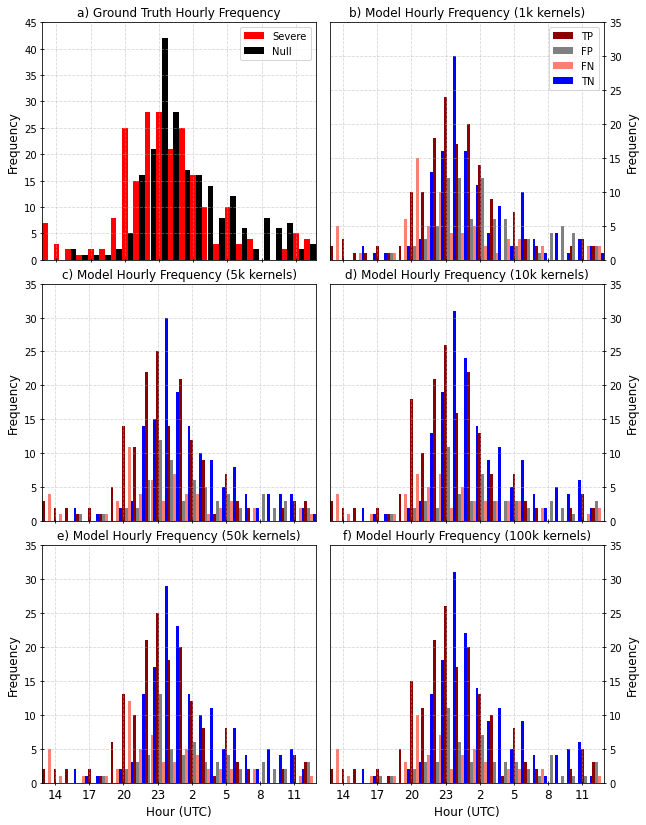

In [6]:
# %-----------------------------------------------------

fig = plt.figure(figsize=(8., 11.))

# %-----------------------------------------------------

ax1 = fig.add_axes([0.0, 0.66, 0.475, 0.3])

# bar width 1/2 for 2 bars per x-tick
width = 0.5

ax1.set_title('a) Ground Truth Hourly Frequency', fontsize=12)

rects1 = ax1.bar(np.arange(0,24),         svwx_trth_freq, width, color='red')
rects2 = ax1.bar(np.arange(0,24) + width, null_trth_freq, width, color='k')

ax1.set_xticks([1,4,7,10,13,16,19,22])
ax1.set_xticklabels(grnd_trth_hour[1::3], fontsize=12)
ax1.set_yticks([0,5,10,15,20,25,30,35,40,45])
#ax1.set_xlabel('Hour (UTC)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.margins(x=0)
ax1.grid(alpha=0.5, ls='--')

ax1.legend([rects1, rects2],
          ["Severe", "Null"], loc="upper right", fontsize=10)

ax1.tick_params(axis='both', labelbottom=False, labelleft=True, labelright=False, direction='inout')


# %-----------------------------------------------------


# bar width 1/4 for 4 bars per x-tick
width = 0.25

tphr_freq, fphr_freq, fnhr_freq, tnhr_freq = conf_matrix_hour_freq(
    tpi_1k, fpi_1k, fni_1k, tni_1k, grnd_hour)

ax2 = fig.add_axes([0.5, 0.66, 0.475, 0.3])

ax2.set_title('b) Model Hourly Frequency (1k kernels)', fontsize=12)

rects1 = ax2.bar(np.arange(0,24),           tphr_freq, width, color='darkred')
rects2 = ax2.bar(np.arange(0,24) + width,   fphr_freq, width, color='grey')
rects3 = ax2.bar(np.arange(0,24) + width*2, fnhr_freq, width, color='salmon')
rects4 = ax2.bar(np.arange(0,24) + width*3, tnhr_freq, width, color='blue')

ax2.set_xticks([1,4,7,10,13,16,19,22])
#ax2.set_xticklabels(grnd_trth_hour[1::3], fontsize=12)
ax2.set_yticks([0,5,10,15,20,25,30,35])
#ax2.set_xlabel('Hour (UTC)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.margins(x=0)
ax2.grid(alpha=0.5, ls='--')

ax2.tick_params(axis='both', labelbottom=False, labelleft=False, 
                labelright=True, direction='inout')

ax2.legend([rects1, rects2, rects3, rects4],
           ["TP", "FP", "FN", "TN"], loc="upper right", fontsize=10)

# %-----------------------------------------------------

tphr_freq, fphr_freq, fnhr_freq, tnhr_freq = conf_matrix_hour_freq(
    tpi_5k, fpi_5k, fni_5k, tni_5k, grnd_hour)

ax3 = fig.add_axes([0.0, 0.33, 0.475, 0.3])

ax3.set_title('c) Model Hourly Frequency (5k kernels)', fontsize=12)

ax3.bar(np.arange(0,24),           tphr_freq, width, color='darkred')
ax3.bar(np.arange(0,24) + width,   fphr_freq, width, color='grey')
ax3.bar(np.arange(0,24) + width*2, fnhr_freq, width, color='salmon')
ax3.bar(np.arange(0,24) + width*3, tnhr_freq, width, color='blue')

ax3.set_xticks([1,4,7,10,13,16,19,22])
#ax3.set_xticklabels(grnd_trth_hour[1::3], fontsize=12)
ax3.set_yticks([0,5,10,15,20,25,30,35])
#ax3.set_xlabel('Hour (UTC)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.margins(x=0)
ax3.grid(alpha=0.5, ls='--')

ax3.tick_params(axis='both', labelbottom=False, labelleft=True, direction='inout')


# %-----------------------------------------------------


tphr_freq, fphr_freq, fnhr_freq, tnhr_freq = conf_matrix_hour_freq(
    tpi_10k, fpi_10k, fni_10k, tni_10k, grnd_hour)

ax4 = fig.add_axes([0.5, 0.33, 0.475, 0.3])

ax4.set_title('d) Model Hourly Frequency (10k kernels)', fontsize=12)

ax4.bar(np.arange(0,24),           tphr_freq, width, color='darkred')
ax4.bar(np.arange(0,24) + width,   fphr_freq, width, color='grey')
ax4.bar(np.arange(0,24) + width*2, fnhr_freq, width, color='salmon')
ax4.bar(np.arange(0,24) + width*3, tnhr_freq, width, color='blue')

ax4.set_xticks([1,4,7,10,13,16,19,22])
#ax4.set_xticklabels(grnd_trth_hour[1::3], fontsize=12)
ax4.set_yticks([0,5,10,15,20,25,30,35])
#ax4.set_xlabel('Hour (UTC)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.margins(x=0)
ax4.grid(alpha=0.5, ls='--')

ax4.tick_params(axis='both', labelbottom=False, labelleft=False, 
                labelright=True, direction='inout')


# %-----------------------------------------------------


tphr_freq, fphr_freq, fnhr_freq, tnhr_freq = conf_matrix_hour_freq(
    tpi_50k, fpi_50k, fni_50k, tni_50k, grnd_hour)

ax5 = fig.add_axes([0.0, 0., 0.475, 0.3])

ax5.set_title('e) Model Hourly Frequency (50k kernels)', fontsize=12)

ax5.bar(np.arange(0,24),           tphr_freq, width, color='darkred')
ax5.bar(np.arange(0,24) + width,   fphr_freq, width, color='grey')
ax5.bar(np.arange(0,24) + width*2, fnhr_freq, width, color='salmon')
ax5.bar(np.arange(0,24) + width*3, tnhr_freq, width, color='blue')

ax5.set_xticks([1,4,7,10,13,16,19,22])
ax5.set_xticklabels(grnd_trth_hour[1::3], fontsize=12)
ax5.set_yticks([0,5,10,15,20,25,30,35])
ax5.set_xlabel('Hour (UTC)', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
ax5.margins(x=0)
ax5.grid(alpha=0.5, ls='--')

ax5.tick_params(axis='both', labelbottom=True, labelleft=True, direction='inout')


# %-----------------------------------------------------


tphr_freq, fphr_freq, fnhr_freq, tnhr_freq = conf_matrix_hour_freq(
    tpi_100k, fpi_100k, fni_100k, tni_100k, grnd_hour)

ax6 = fig.add_axes([0.5, 0., 0.475, 0.3])

ax6.set_title('f) Model Hourly Frequency (100k kernels)', fontsize=12)

ax6.bar(np.arange(0,24),           tphr_freq, width, color='darkred')
ax6.bar(np.arange(0,24) + width,   fphr_freq, width, color='grey')
ax6.bar(np.arange(0,24) + width*2, fnhr_freq, width, color='salmon')
ax6.bar(np.arange(0,24) + width*3, tnhr_freq, width, color='blue')

ax6.set_xticks([1,4,7,10,13,16,19,22])
ax6.set_xticklabels(grnd_trth_hour[1::3], fontsize=12)
ax6.set_yticks([0,5,10,15,20,25,30,35])
ax6.set_xlabel('Hour (UTC)', fontsize=12)
ax6.set_ylabel('Frequency', fontsize=12)
ax6.yaxis.set_label_position("right")
ax6.yaxis.tick_right()
ax6.margins(x=0)
ax6.grid(alpha=0.5, ls='--')

ax6.tick_params(axis='both', labelbottom=True, labelleft=False, 
                labelright=True, direction='inout')


# %-----------------------------------------------------

#plt.savefig(f'{results_directory}freqfig.png', bbox_inches='tight', dpi=200, transparent=True)
plt.show()

# %-----------------------------------------------------

Plotting just two plots in one figure (ground truth and 10,000 kernel model diurnal cycle results).

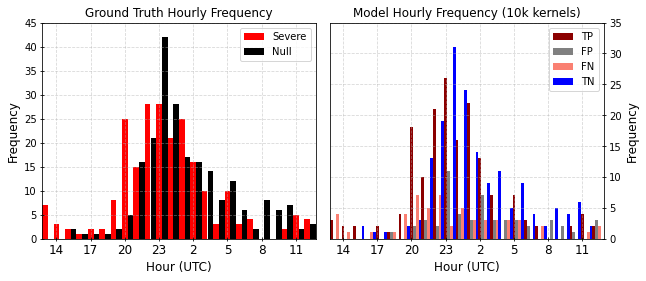

In [7]:
# %-----------------------------------------------------

fig = plt.figure(figsize=(8., 3.))

# %-----------------------------------------------------

ax1 = fig.add_axes([0.0, 0.0, 0.475, 1.])

# bar width 1/2 for 2 bars per x-tick
width = 0.5

ax1.set_title('Ground Truth Hourly Frequency', fontsize=12)

rects1 = ax1.bar(np.arange(0,24),         svwx_trth_freq, width, color='red')
rects2 = ax1.bar(np.arange(0,24) + width, null_trth_freq, width, color='k')

ax1.set_xticks([1,4,7,10,13,16,19,22])
ax1.set_xticklabels(grnd_trth_hour[1::3], fontsize=12)
ax1.set_yticks([0,5,10,15,20,25,30,35,40,45])
ax1.set_xlabel('Hour (UTC)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.margins(x=0)
ax1.grid(alpha=0.5, ls='--')

ax1.legend([rects1, rects2],
          ["Severe", "Null"], loc="upper right", fontsize=10)

ax1.tick_params(axis='both', labelbottom=True, labelleft=True, direction='inout')


# %-----------------------------------------------------
# %-----------------------------------------------------


# bar width 1/4 for 4 bars per x-tick
width = 0.25

tphr_freq, fphr_freq, fnhr_freq, tnhr_freq = conf_matrix_hour_freq(
    tpi_10k, fpi_10k, fni_10k, tni_10k, grnd_hour)

ax4 = fig.add_axes([0.5, 0., 0.475, 1.0])

ax4.set_title('Model Hourly Frequency (10k kernels)', fontsize=12)

rects1 = ax4.bar(np.arange(0,24),           tphr_freq, width, color='darkred')
rects2 = ax4.bar(np.arange(0,24) + width,   fphr_freq, width, color='grey')
rects3 = ax4.bar(np.arange(0,24) + width*2, fnhr_freq, width, color='salmon')
rects4 = ax4.bar(np.arange(0,24) + width*3, tnhr_freq, width, color='blue')

ax4.set_xticks([1,4,7,10,13,16,19,22])
ax4.set_xticklabels(grnd_trth_hour[1::3], fontsize=12)
ax4.set_yticks([0,5,10,15,20,25,30,35])
ax4.set_xlabel('Hour (UTC)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.margins(x=0)
ax4.grid(alpha=0.5, ls='--')

ax4.tick_params(axis='both', labelbottom=True, labelleft=False, 
                labelright=True, direction='inout')

ax4.legend([rects1, rects2, rects3, rects4],
           ["TP", "FP", "FN", "TN"], loc="upper right", fontsize=10)


# %-----------------------------------------------------
# %-----------------------------------------------------

#plt.savefig(f'{results_directory}freqfig.png', bbox_inches='tight', transparent=True, dpi=200)
plt.show()

# %-----------------------------------------------------